### Preprocesamiento de los datos

Para lograr implementar cualquier modelo con éxito y resolver un problema, es importante realizar un preprocesamiento a los datos que se vayan a usar. Este proceso siempre se debe emplear porque los datos pueden estar sucios, contener ruido, datos faltantes, caracteres especiales, signos de puntuación, entre otras, los cuales no permitirán que el modelo sea entrenado correctamente. Por tal motivo, a continuación se efectúa el proceso de verificación, limpieza, transformación y división del conjunto para entrenamiento y pruebas

In [1]:
#Cargar librerias
import pandas as pd
import numpy as np
import nltk 
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re,string,unicodedata

from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

#Modelos
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import warnings
warnings.filterwarnings('ignore')


El conjunto de datos que utilizara para el proceso de análisis de sentimientos en reseñas de películas, está conformado por 50 mil datos. El conjunto de datos está constituido por dos columnas (review, sentiment). Para cargar los datos, se utiliza la librería Pandas y se muestra los 10 primeros datos que contiene el datset. La columna review contiene información con datos sucios y ruidos.

In [2]:
#Muestra los 10 primeros review
data=pd.read_csv('IMDB Dataset.csv')
print(data.shape)
data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
#Imprime el review que se encuentra en la posición 4 
data['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

### Verificar datos

Una vez cargados los datos se verifica que el dataset no contenga valores nulos. Y para esto, se utiliza la función isnull para la comprobación. Esta función devolverá "True" si encuentra componentes faltantes y "False" para los componentes que no faltan. Finalmente, se contará todos los valores "True" y como se puede observar, el conteo dio 0, es decir, no existe valores nulos en todo el dataset.

In [4]:
#Se verifica si existe valores nullos en el dataset
data.isnull().sum()

review       0
sentiment    0
dtype: int64

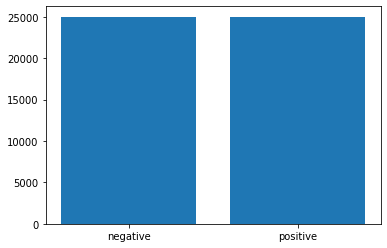

In [5]:
classes = data.sentiment.unique()
counts = []

for i in classes:
  count = len(data[data.sentiment==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

### Tokenizar

La tokenización sirve para encontrar y comprender patrones en el texto, el cual es útil para realizar el proceso de análisis de sentimiento. Este proceso es base para derivación y lematización del texto. Por tal motivo, en la siguiente línea de código se emplea el token y se configura las palabras vacías en el idioma en inglés.

In [6]:
#Tokenización de texto
tokenizer=ToktokTokenizer()

#Configuración de palabras vacías en inglés
stopword_list=nltk.corpus.stopwords.words('english')

### Eliminar etiquetas html y ruido en el texto

En las siguientes líneas de código se realiza el proceso de limpieza de los datos. Se desarrolla una función para eliminar cualquier elemento HTML que exista en los review. Otra función para eliminar expresiones regulares, como lo son corchetes, llaves, asteriscos, comillas, entre otros. También se elimina texto ruidoso y finalmente, la eliminación de caracteres especiales.

In [7]:
#Eliminar etiquetas de HTML
def etiqueta_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Eliminar algunas expresiones
def eliminar_corchetes(text):
    return re.sub('\[[^]]*\]', '', text)

#Elimina texto ruidoso
def eliminar_ruido(text):
    text = etiqueta_html(text)
    text = eliminar_corchetes(text)
    return text

#Aplicar la función denoise_text en la columna de review
data['review']=data['review'].apply(eliminar_ruido)

### Eliminación de caracteres especiales 

In [8]:
#Definir función para eliminar caracteres especiales
def eliminar_caracteres_especiales(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Aplicar la función remove_special_characters en la columna review
data['review']=data['review'].apply(eliminar_caracteres_especiales)

### Stemming

La implementación del Stemming se encarga de reducir las palabras a su raíz. Y es útil para asignar varias palabras a una palabra base en específico, esto no solo se hace con palabras, sino también con oraciones. Por tal motivo, en la siguiente línea de código se emplea Steamming en el texto.

In [9]:
#Stemming del texto
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Aplicar la función en la columna review 
data['review']=data['review'].apply(simple_stemmer)

### Eliminar palabras vacías

Con el proceso de tokenización, se desarrolla una función que elimina todas las palabras vacias y se aplica el metodo en la columna review.

In [10]:
#establecer palabras vacías en inglés
stop=set(stopwords.words('english'))

#eliminando las palabras vacías
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Aplicar la función
data['review']=data['review'].apply(remove_stopwords)

### Normalización de los review

Una vez terminado el proceso de limpieza de los datos, se emplea la normalización, es decir, estandariza todos los datos a un solo nive (palabras en minusculas)

In [11]:
#normalized train reviews
norm_train_reviews=data.review[:35000]

#Normalized test reviews
norm_test_reviews=data.review[35000:]

### Modelo Bags of words

Para realizar análisis de sentimiento se necesita crear una bolsa de palabras. El modelo Bag of Words es utilizado para representar los datos de prueba. Este método es empleado para PLN y IR. Para implementar este modelo se genera un vector de bolsas de palabras y después se hace un ajuste de los datos.

In [12]:
#Vectorizar para armar bolsa de palabras
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

#Transformar datos
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('Ajuste de los datos de entrenamiento:',cv_train_reviews.shape)
print('Ajuste de los datos de prueba:',cv_test_reviews.shape)


Ajuste de los datos de entrenamiento: (35000, 5533754)
Ajuste de los datos de prueba: (15000, 5533754)


### Modelo TFIDF

In [13]:
#Vectorizar Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

#Transformar datos y hacer fit
tv_train_reviews=tv.fit_transform(norm_train_reviews)

#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)

print('Ajuste de los datos de entrenamiento::',tv_train_reviews.shape)
print('Ajuste de los datos de prueba:',tv_test_reviews.shape)

Ajuste de los datos de entrenamiento:: (35000, 5533754)
Ajuste de los datos de prueba: (15000, 5533754)


### Transformación del etiquetado a datos binarios

Una vez ya procesado los datos pertenecientes a la columna review, ahora solo falta la columna sentiment. En el caso de este dataset, la columna sentiment únicamente tiene dos valores: positive, negative. Y como tal, estos valores se los pueden convertir en números binarios, en donde el 0 representa a los negativos y el 1 a los positivos. La función LabelBinariser hace este proceso de binarización.

In [19]:
#Función para convertir en binarios
lb=LabelBinarizer()

#transformación de los datos 
data['sentiment']=lb.fit_transform(data['sentiment'])

print(data['sentiment'].shape)

(50000,)


### Dividir el conjunto de las Y.

In [20]:
train_sentiments=data['sentiment'][:35000]
test_sentiments=data['sentiment'][35000:]

Con el siguiente codigo se genera un nuevo archivo csv con los datos limpios. 

In [23]:
#ruta = "review_limpios.csv"
#data.to_csv(ruta)
data.head()

,review,sentiment
0,one review ha mention watch 1 oz episod youll ...,1
1,wonder littl product film techniqu veri unassu...,1
2,thought thi wa wonder way spend time hot summe...,1
3,basic famili littl boy jake think zombi hi clo...,0
4,petter mattei love time money visual stun film...,1


#### Selección de caracteristicas 

Como se puede observar, mi dataset solo tienen una caracteristica, por lo tanto, no aplico ningun algoritmo para selección de caracteristicas. 

#### Qué modelo de ML/DL/DM usted aplicará a su proyecto para ser resuelto?

El modelo principal que se aplicara para analizar sentimiento en el texto, es un algoritmo de Deep Learning basico, es cual es LSTM. Este modelo permite tener mayor precisión gracias a su memoria a largo plazo a comparación de los modelos tradicionales. 

#### Con qué modelos comparará ese modelo y por qué?


Los modelos escogidos para comparar el modelo de LSTM son: regresión logística y SVM. Estos modelos se escogieron porque según todos los artículos revisados, la mayoría utilizaban dichos modelos y obtuvieron buenos resultados de acurracy.

#### Cuáles son los hyperparameters que utilizará para cada modelo? Interprete los resultados

#### SVM

En el modelo SVM, el primer hiperparámetro que se debería escoger son los nucleas (kernel). Estos núcleos pueden ser de varios tipos, y los que comúnmente se usan son los: linear, poly, RBF y sigmoid. En el caso de que no se especifique el tipo de de núcleo a utilizar, automáticamente el algoritmo utilizara RBF.

Otro hiperparámetro de SVM también es la penalización, que viene siendo el valor de C. Este valor, como se mencionó anteriormente, también controla la fuerza de penalización; estos números tienen que ser de tipo flotante, es decir, decimales. En el caso de que no se especifique el valor de C, se tomara el numero predeterminado que es 1.0.

param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [50, 10, 1.0, 0.1, 0.01],
}

#### Regressión logistica

Los hiperparámetros de regresión logísticas realmente no tienen una forma criticar para ajustar los parámetros. Muchas veces se puede observar algunas diferencias que puede ser útiles en la convergencia del modelo o el rendimiento dependiendo del solucionador (solver). El solver puede ser de tipo: newton-cg, lbfgs, liblinear, sag y saga. Para poder regularizar los solucionadores se utiliza el hiperparámetro penalización (penalty), que puden ser de tipo: none (no añade penalización), L2 ( es el tipo de penalización predeterminada), L1 (añade un término de penalización L1) y elasticnet (añade términos de penalización L1 y L2).

Los regularizadores se puden utilizar dependiendo el tipo de solucionador, por ejemplo, los solucionadores newton-cg, sag y lbfgs solo admiten la regularización L2 con formulación primaria o sin regularización. El solucionador liblineal admite la regularización de L1 y L2, con una formulación dual solo para la penalización de L2. La regularización de Elastic-Net solo es compatible con el solucionador saga. Después se encuentra el hiperparámetro C, el cual controla la potencia o fuerza de la penalización. Estos valores pueden estar entre 100, 10, 1.0, 0.1 y 0.01.

El hiperparámetro max_iter se puede definir para controlar el número máximo de interacciones que se necesitan para el solucionar converja. El max_iter puede tener cualquier número entero, pero el numero predeterminado es 100. El random_state es otro tipo de hiperparámetro que es utilizado para mezclar datos, pero, solo es compatible para solucionadores: sag, saga o liblinear'int. Estos pueden ser de tipo: RandomState instance, none, es cual es el predeterminado y cualquier número entero. Estos dos últimos hiperparámetros se los puede utilizar dependiendo el solucionador que se elija.

In [ ]:
param_grid = {
    'imputer__strategy': ['mean', 'median', 'constant'],
    'imputer__add_indicator': [True, False],
    'regressor__alpha': [10, 100, 200],
}

#### LSTM

El algoritmo de LST o Redes neuronales recurrentes, tienen varios parámetros que se pueden ajustar, pero solo se definirán los más importantes. El hiperparámetro en donde se define los nodos a utilizar y capas ocultas son unos de los parámetros más relevantes. Para este parámetro no existe un número final definido para usar, esto depende de cada problema en particular. Como conocimiento general la utilización de una capa oculta es suficiente para problemas simples. Como segundo parámetro se puede mencionar la elección del número en una capa densa, la cual es la más utilizadas. Estas capas mejoran la precisión del modelo, y se tiene visto que entre 5 a 10 unidades por cada una de capa es una base.

Otros de los parámetros es el abandono (dropout), el cual ayuda a evitar que haya un sobreajuste en el modelo por los datos de entrenamiento. El valor de dropout debe estar definido entre 0.2 y 0.5, para lograr mantener la presión del modelo y evitar un sobreajuste. Y por último, otro de los parámetros más importantes es el número de épocas (Batch Size), este establece un número de muestras en las que se enfoca primero antes de que trabajen o se actualicen los parámetros internos. El valor predeterminado para este parámetro es de 32, pero para experimentar se puede variar entre 64, 128 y 256.

In [ ]:
param_grid = {
    'Dense': [5, 6, 7, 8, 9, 10],
    'Hidden Layers': [1, 2],
    'Dropout': [0.2, 0.3, 0.4, 0.5],
    'Batch Size': [1, 2, 3, 4, 5],
}

#### Qué métricas utilizará para evaluar su modelo? Comente sobre cada métrica y qué valor espera.

La metrica principal que se utilizara para comparar los modelos es el acurracy de cada uno. Pero para obtener mayor detalle de la clasificación que realiza cada modelos, se generar un reporte de clasificación. El reporte de clasificación obtiene información sobre la presición, recall, f1 score y support. El acurry en la medida que se obtinene para ver que tan serca esta de tener el modelos valores reales. La presición, el recall, F1-score son metricas adicionales que puede obtner para observar con mayor detalle del modelo. 
Los valores en las metricas puede variar dependiendo del modelo. Pero se espera tener valores mayores al 70%. 